# Corporate Credit Rating Dataset: Exploratory Data Analysis and Data Preparation

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import warnings


The  [Corporate Credit Rating](https://www.kaggle.com/datasets/agewerc/corporate-credit-rating/data) dataset is obtained from Kaggle .

In [2]:
# Load the data from .csv file 
ratings_df = pd.read_csv('./raw_corporate_rating.csv')
ratings_df.head()

,Rating,Name,Symbol,Rating Agency Name,Date,Sector,currentRatio,quickRatio,cashRatio,daysOfSalesOutstanding,...,effectiveTaxRate,freeCashFlowOperatingCashFlowRatio,freeCashFlowPerShare,cashPerShare,companyEquityMultiplier,ebitPerRevenue,enterpriseValueMultiple,operatingCashFlowPerShare,operatingCashFlowSalesRatio,payablesTurnover
0,A,Whirlpool Corporation,WHR,Egan-Jones Ratings Company,11/27/2015,Consumer Durables,0.945894,0.426395,0.099690,44.203245,...,0.202716,0.437551,6.810673,9.809403,4.008012,0.049351,7.057088,15.565438,0.058638,3.906655
1,BBB,Whirlpool Corporation,WHR,Egan-Jones Ratings Company,2/13/2014,Consumer Durables,1.033559,0.498234,0.203120,38.991156,...,0.074155,0.541997,8.625473,17.402270,3.156783,0.048857,6.460618,15.914250,0.067239,4.002846
2,BBB,Whirlpool Corporation,WHR,Fitch Ratings,3/6/2015,Consumer Durables,0.963703,0.451505,0.122099,50.841385,...,0.214529,0.513185,9.693487,13.103448,4.094575,0.044334,10.491970,18.888889,0.074426,3.483510
3,BBB,Whirlpool Corporation,WHR,Fitch Ratings,6/15/2012,Consumer Durables,1.019851,0.510402,0.176116,41.161738,...,1.816667,-0.147170,-1.015625,14.440104,3.630950,-0.012858,4.080741,6.901042,0.028394,4.581150
4,BBB,Whirlpool Corporation,WHR,Standard & Poor's Ratings Services,10/24/2016,Consumer Durables,0.957844,0.495432,0.141608,47.761126,...,0.166966,0.451372,7.135348,14.257556,4.012780,0.053770,8.293505,15.808147,0.058065,3.857790


The dataset `ratings_df` consists of 2029 entries (rows) and 31 columns. Each entry represents a big US firm traded on NYSE or Nasdaq. The ratings span the period from 2010 to 2016.

In [3]:
# Check the number of entries, names of the columns and data types
ratings_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2029 entries, 0 to 2028
Data columns (total 31 columns):
 #   Column                              Non-Null Count  Dtype  
---  ------                              --------------  -----  
 0   Rating                              2029 non-null   object 
 1   Name                                2029 non-null   object 
 2   Symbol                              2029 non-null   object 
 3   Rating Agency Name                  2029 non-null   object 
 4   Date                                2029 non-null   object 
 5   Sector                              2029 non-null   object 
 6   currentRatio                        2029 non-null   float64
 7   quickRatio                          2029 non-null   float64
 8   cashRatio                           2029 non-null   float64
 9   daysOfSalesOutstanding              2029 non-null   float64
 10  netProfitMargin                     2029 non-null   float64
 11  pretaxProfitMargin                  2029 no

The dataset has 593 unique US firms, as seen from `ratings_df.Name.value_counts()`.  

In [4]:
ratings_df.Name.value_counts()

BCE, Inc.                      7
Walt Disney Company (The)      7
CSX Corporation                7
CoreLogic, Inc.                7
PLDT Inc.                      7
                              ..
Equinix, Inc.                  1
Centrus Energy Corp.           1
Alcoa Corporation              1
Las Vegas Sands Corp.          1
Gulfport Energy Corporation    1
Name: Name, Length: 593, dtype: int64

## Credit Ratings

The target variable is the `Rating` column, representing the credit rating assigned by agencies. Credit ratings categorize a company's ability to repay debt. Taking a closer look at the list of agencies and their different ratings using `ratings_df['Rating Agency Name'].value_counts()` and `ratings_df.groupby('Rating Agency Name')['Rating'].unique()`:


In [5]:
# Get the list of Rating Agency Names
ratings_df['Rating Agency Name'].value_counts()

Standard & Poor's Ratings Services    744
Egan-Jones Ratings Company            603
Moody's Investors Service             579
Fitch Ratings                         100
DBRS                                    3
Name: Rating Agency Name, dtype: int64

In [6]:
# Check the different Rating Agencies and the list of Ratings they provide
ratings_df.groupby('Rating Agency Name')['Rating'].unique()

Rating Agency Name
DBRS                                                             [AA, BBB]
Egan-Jones Ratings Company            [A, BBB, AA, B, CCC, BB, AAA, CC, C]
Fitch Ratings                                 [BBB, A, AA, CC, BB, B, CCC]
Moody's Investors Service                 [A, BBB, BB, B, AAA, CCC, C, AA]
Standard & Poor's Ratings Services    [BBB, A, BB, AA, B, D, AAA, CCC, CC]
Name: Rating, dtype: object

The dataset shows an imbalance in credit ratings, with varying frequencies for each rating category as it is evident from `ratings_df.Rating.value_counts()`

In [7]:
# Check the different types of Ratings and their counts
ratings_df.Rating.value_counts()

BBB    671
BB     490
A      398
B      302
AA      89
CCC     64
AAA      7
CC       5
C        2
D        1
Name: Rating, dtype: int64

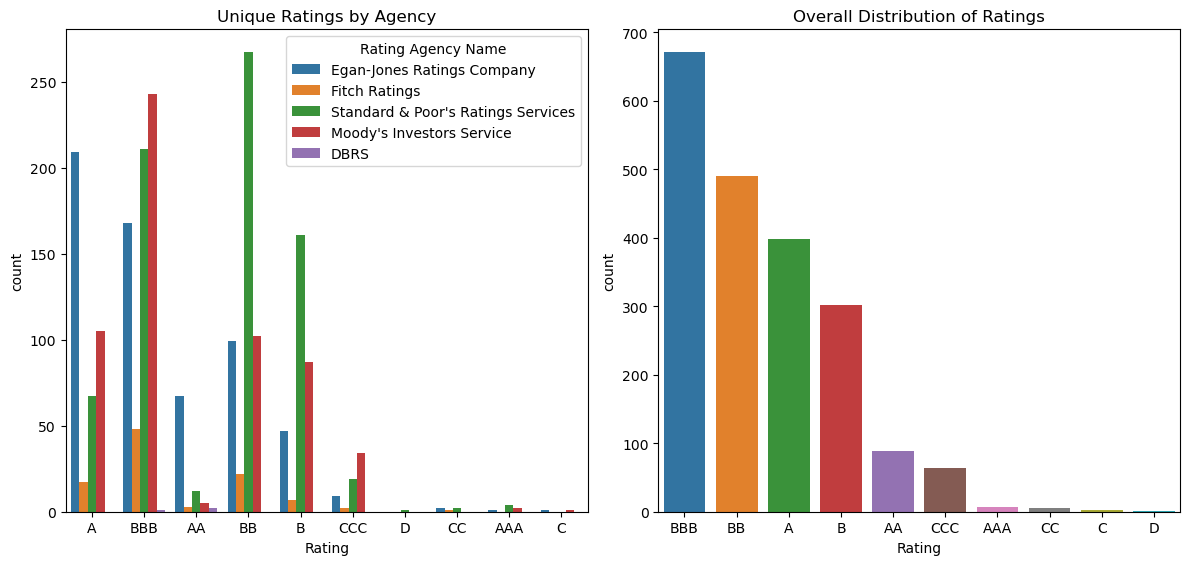

In [8]:
# Plot unique ratings by agency
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
sns.countplot(x='Rating', hue='Rating Agency Name', data=ratings_df)
plt.title('Unique Ratings by Agency')

# Plot overall distribution of ratings
plt.subplot(1, 2, 2)
sns.countplot(x='Rating', data=ratings_df, order=ratings_df['Rating'].value_counts().index)
plt.title('Overall Distribution of Ratings')

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

# Address Imbalance in the Data
## Simplify and merge labels
It is also important to note that we are working with ratings from different agencies. One way to address this is to simplify and merge the ratings labels according to the following table from [Investopedia: Corporate Credit Ratings](https://www.investopedia.com/terms/c/corporate-credit-rating.asp)
| Moody's     | Standard & Poor's |  Fitch            |   Grade      | Risk         |
|-------------|-------------------|-------------------|--------------|--------------|
| Aaa         | AAA               | AAA               | Investment   | Lowest Risk  |
| Aa          | AA                | AA                | Investment   | Low Risk     |
| A           | A                 | A                 | Investment   | Low Risk     |
| Baa         | BBB               | BBB               | Investment   | Medium Risk  |
| Ba, B       | BB, B             | BB, B             | Junk         | High Risk    |
| Caa/Ca      | CCC/CC/C          | CCC/CC/C          | Junk         | Highest Risk |
| C           | D                 | D                 | Junk         | In Default   |

Instead of 10 different rating categories, we have now 6 categories. 
Using a dictionary for the mapping of new ratings and old ratings and `ratings_df['Rating'].map(rating_dict)` , we have:

In [9]:
rating_dict = {'AAA':'Lowest Risk', 
               'AA':'Low Risk',
               'A':'Low Risk',
               'BBB':'Medium Risk', 
               'BB':'High Risk',
               'B':'High Risk',
               'CCC':'Highest Risk', 
               'CC':'Highest Risk',
               'C':'Highest Risk',
               'D':'In Default'}

ratings_df.Rating = ratings_df.Rating.map(rating_dict)
ratings_df.Rating.value_counts()

High Risk       792
Medium Risk     671
Low Risk        487
Highest Risk     71
Lowest Risk       7
In Default        1
Name: Rating, dtype: int64

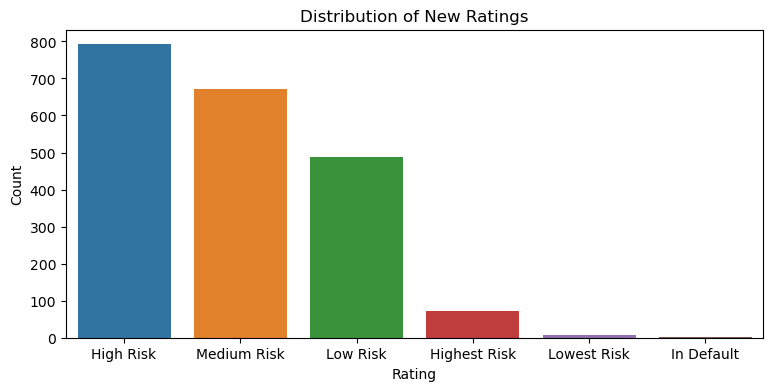

In [10]:
plt.figure(figsize=(9, 4))
sns.countplot(x='Rating', data=ratings_df, order=ratings_df['Rating'].value_counts().index)
plt.title('Distribution of New Ratings')
plt.xlabel('Rating')
plt.ylabel('Count')
plt.show()

## Filter data

The rows with the Ratings: `'Lowest Risk` and `'In Default` are dropped from the dataset given their small value counts.

In [11]:
ratings_df = ratings_df[ratings_df['Rating']!='Lowest Risk'] # filter Lowest Risk
ratings_df = ratings_df[ratings_df['Rating']!='In Default']  # filter In Default
ratings_df.reset_index(inplace = True, drop=True) # reset index

Although improved, our dataset still remains unbalanced.  To tackle this, SMOTE Analysis can be applied, after splitting data for train and test, to generate synthetic instances for the minority classes using the `SMOTE` function from the `imblearn.over_sampling`.  

## Input Features:
The other columns in the dataset are the input features related to financial indicators and information about the company. 

The 5 features with the company information such as `Name`, `Symbol` (for trading), `Rating Agency Name`, `Date`, and `Sector` provide context and additional details for analysis but their inclusion in the model may not be necessary for the specific task of credit rating prediction.  Different sectors exhibit distinct economic characteristics and respond differently to market conditions. By incorporating the `Sector` variable, we aim to enhance the granularity of our analysis, ensuring that the machine learning model discerns sector-specific trends and challenges.

In [12]:
# Drop the Columns we don't want in our model input data

columns_to_drop = [ 'Name', 'Symbol', 'Rating Agency Name' ,'Date']
ratings_df = ratings_df.drop(columns=columns_to_drop)
ratings_df

,Rating,Sector,currentRatio,quickRatio,cashRatio,daysOfSalesOutstanding,netProfitMargin,pretaxProfitMargin,grossProfitMargin,operatingProfitMargin,...,effectiveTaxRate,freeCashFlowOperatingCashFlowRatio,freeCashFlowPerShare,cashPerShare,companyEquityMultiplier,ebitPerRevenue,enterpriseValueMultiple,operatingCashFlowPerShare,operatingCashFlowSalesRatio,payablesTurnover
0,Low Risk,Consumer Durables,0.945894,0.426395,0.099690,44.203245,0.037480,0.049351,0.176631,0.061510,...,0.202716,0.437551,6.810673,9.809403,4.008012,0.049351,7.057088,15.565438,0.058638,3.906655
1,Medium Risk,Consumer Durables,1.033559,0.498234,0.203120,38.991156,0.044062,0.048857,0.175715,0.066546,...,0.074155,0.541997,8.625473,17.402270,3.156783,0.048857,6.460618,15.914250,0.067239,4.002846
2,Medium Risk,Consumer Durables,0.963703,0.451505,0.122099,50.841385,0.032709,0.044334,0.170843,0.059783,...,0.214529,0.513185,9.693487,13.103448,4.094575,0.044334,10.491970,18.888889,0.074426,3.483510
3,Medium Risk,Consumer Durables,1.019851,0.510402,0.176116,41.161738,0.020894,-0.012858,0.138059,0.042430,...,1.816667,-0.147170,-1.015625,14.440104,3.630950,-0.012858,4.080741,6.901042,0.028394,4.581150
4,Medium Risk,Consumer Durables,0.957844,0.495432,0.141608,47.761126,0.042861,0.053770,0.177720,0.065354,...,0.166966,0.451372,7.135348,14.257556,4.012780,0.053770,8.293505,15.808147,0.058065,3.857790
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2016,Medium Risk,Capital Goods,11.757767,7.115059,7.057420,1.079762,0.056706,0.086376,1.000000,0.077844,...,0.343500,0.953231,50.293155,230.194971,1.759461,0.086376,15.867701,52.760726,0.083018,15.758348
2017,High Risk,Capital Goods,2.962788,1.294743,0.428234,30.602414,-0.169983,-0.267117,0.198649,-0.248509,...,0.363636,0.602645,5.563630,5.958956,1.614282,-0.267117,-4.729967,9.232021,0.114089,14.542373
2018,High Risk,Finance,0.883875,0.842553,0.233830,147.599371,-0.007458,0.000219,0.384390,0.185418,...,35.017544,0.926665,1.459801,1.056480,4.034952,0.265092,9.358311,1.575328,0.283634,2.300168
2019,High Risk,Finance,0.911713,0.748356,0.310640,131.644566,0.087365,0.130692,0.414916,0.286236,...,0.331525,0.692804,0.744377,1.470201,3.825856,0.130692,22.440102,1.074441,0.217783,1.997608


# Encode categorical data

The categorical variables `Rating` and`Sector` are converted into numerical labels using the `LabelEncoder` from scikit-learn's preprocessing module, assigning a distinct integer code to each unique label. 

In [13]:
from sklearn import preprocessing
le = preprocessing.LabelEncoder()

# encode Rating
le.fit(ratings_df.Rating)
ratings_df.Rating = le.transform(ratings_df.Rating) 

# encode Sector
le.fit(ratings_df.Sector)
ratings_df.Sector = le.transform(ratings_df.Sector) 

# Input Features

The dataset includes 25 financial indicators that can be categorized into different groups. These financial indicators collectively provide a comprehensive view of a company's financial health and performance, contributing to the evaluation of its creditworthiness.

**(I) Liquidity Measurement Ratios:** These ratios provide insights into a company's short-term financial health and ability to meet its immediate obligations.
1. `currentRatio`: Indicates the company's ability to cover short-term liabilities with short-term assets.
2. `quickRatio`: Measures the company's ability to cover immediate liabilities without relying on inventory.
3. `cashRatio`: Reflects the proportion of cash and cash equivalents to current liabilities.
4. `daysOfSalesOutstanding`: Measures the average number of days it takes for a company to collect payment after a sale.

**(II). Profitability Indicator Ratios:** These ratios evaluate a company's ability to generate profits relative to its revenue and investments.

5. `netProfitMargin`: Represents the percentage of profit relative to total revenue.
6. `pretaxProfitMargin`: Measures profitability before taxes are considered.
7. `grossProfitMargin`: Indicates the percentage of revenue retained after deducting the cost of goods sold.
8. `operatingProfitMargin`: Reflects the company's profitability from its core operations.
9. `returnOnAssets`: Gauges how efficiently a company utilizes its assets to generate earnings.
10. `returnOnEquity`: Measures the return generated on shareholders' equity.
11. `returnOnCapitalEmployed`: Assesses the efficiency of capital utilization in generating profits.
12. `ebitPerRevenue`: Measures earnings before interest and taxes relative to revenue.

**(III) Debt Ratios:** These ratios assess the company's leverage and debt management.

13. `debtEquityRatio`: Measures the proportion of debt relative to equity.
14. `debtRatio` : Represents the percentage of a company's assets financed by debt.

**(IV) Operating Performance Ratios:** These ratios focus on operational efficiency and effectiveness.

15. `assetTurnover`: Evaluates how efficiently a company utilizes its assets to generate sales revenue.
16. `fixedAssetTurnover` : Measures the efficiency of generating sales from fixed assets.
17. `payablesTurnover`: Measures the efficiency of a company's payment of its liabilities.

**(V) Cash Flow Indicator Ratios:** These ratios delve into a company's cash flow dynamics, providing insights into its financial sustainability. 

18. `operatingCashFlowPerShare`: Reflects the cash generated by core business operations per share.
19. `freeCashFlowPerShare`: Measures the amount of cash available to shareholders after covering operational expenses and capital expenditures.
20. `cashPerShare`: Represents the amount of cash available per outstanding share.
21. `operatingCashFlowSalesRatio`: Evaluates the percentage of sales revenue converted into cash from operating activities.
22. `freeCashFlowOperatingCashFlowRatio`: Measures the efficiency of converting operating cash flow into free cash flow.
23. `effectiveTaxRate`: Reflects the company's tax efficiency.
24. `companyEquityMultiplier`: Indicates the multiplier effect on equity due to debt
25. `enterpriseValueMultiple`: Evaluates a company's overall value relative to its earnings.

# Descriptive Statistics

The `describe()` function gives statistical descriptions like `mean`, `min`, `max`, `percentiles` of the numerical financial indicators. Comparison of the mean to the median and examining the range between percentiles, there seems to be an indication of the presence of outliers. 

In [14]:
ratings_df.describe()

,Rating,Sector,currentRatio,quickRatio,cashRatio,daysOfSalesOutstanding,netProfitMargin,pretaxProfitMargin,grossProfitMargin,operatingProfitMargin,...,effectiveTaxRate,freeCashFlowOperatingCashFlowRatio,freeCashFlowPerShare,cashPerShare,companyEquityMultiplier,ebitPerRevenue,enterpriseValueMultiple,operatingCashFlowPerShare,operatingCashFlowSalesRatio,payablesTurnover
count,2021.000000,2021.000000,2021.000000,2021.000000,2021.000000,2021.000000,2021.000000,2021.000000,2021.000000,2021.000000,...,2021.000000,2021.000000,2.021000e+03,2.021000e+03,2021.000000,2021.000000,2021.000000,2.021000e+03,2021.000000,2021.000000
mean,1.513112,4.977239,3.535411,2.657150,0.669048,334.855415,0.278725,0.432721,0.496900,0.588793,...,0.400755,0.408272,5.114871e+03,4.244248e+03,3.335166,0.438715,48.426558,6.540891e+03,1.452142,38.138233
std,1.303252,3.464598,44.139386,33.009920,3.590902,4456.606352,6.076128,9.002733,0.525996,11.246798,...,10.613711,3.803929,1.472059e+05,1.226418e+05,87.702375,9.002047,530.161001,1.778797e+05,19.521704,760.421855
min,0.000000,0.000000,-0.932005,-1.893266,-0.192736,-811.845623,-101.845815,-124.343612,-14.800817,-124.343612,...,-100.611015,-120.916010,-4.912742e+03,-1.915035e+01,-2555.419643,-124.343612,-3749.921337,-1.195049e+04,-4.461837,-76.662850
25%,0.000000,2.000000,1.071930,0.602298,0.131433,22.806507,0.020894,0.025649,0.232565,0.044546,...,0.147837,0.269616,4.094118e-01,1.562116e+00,2.050249,0.028057,6.235759,2.348851e+00,0.073664,2.202394
50%,2.000000,5.000000,1.492804,0.979094,0.297859,42.281804,0.064323,0.084965,0.414217,0.107640,...,0.300439,0.644265,2.123062e+00,3.680425e+00,2.657275,0.087424,9.269746,4.361649e+00,0.132758,5.775840
75%,3.000000,8.000000,2.160710,1.450457,0.625355,59.165369,0.113871,0.144763,0.849693,0.175334,...,0.370239,0.836949,4.230253e+00,8.027524e+00,3.665438,0.149355,12.898855,7.322553e+00,0.239359,9.500424
max,3.000000,11.000000,1725.505005,1139.541703,125.917417,115961.637400,198.517873,309.694856,2.702533,410.182214,...,429.926282,34.594086,5.753380e+06,4.786803e+06,2562.871795,309.694856,11153.607090,6.439270e+06,688.526591,20314.880400


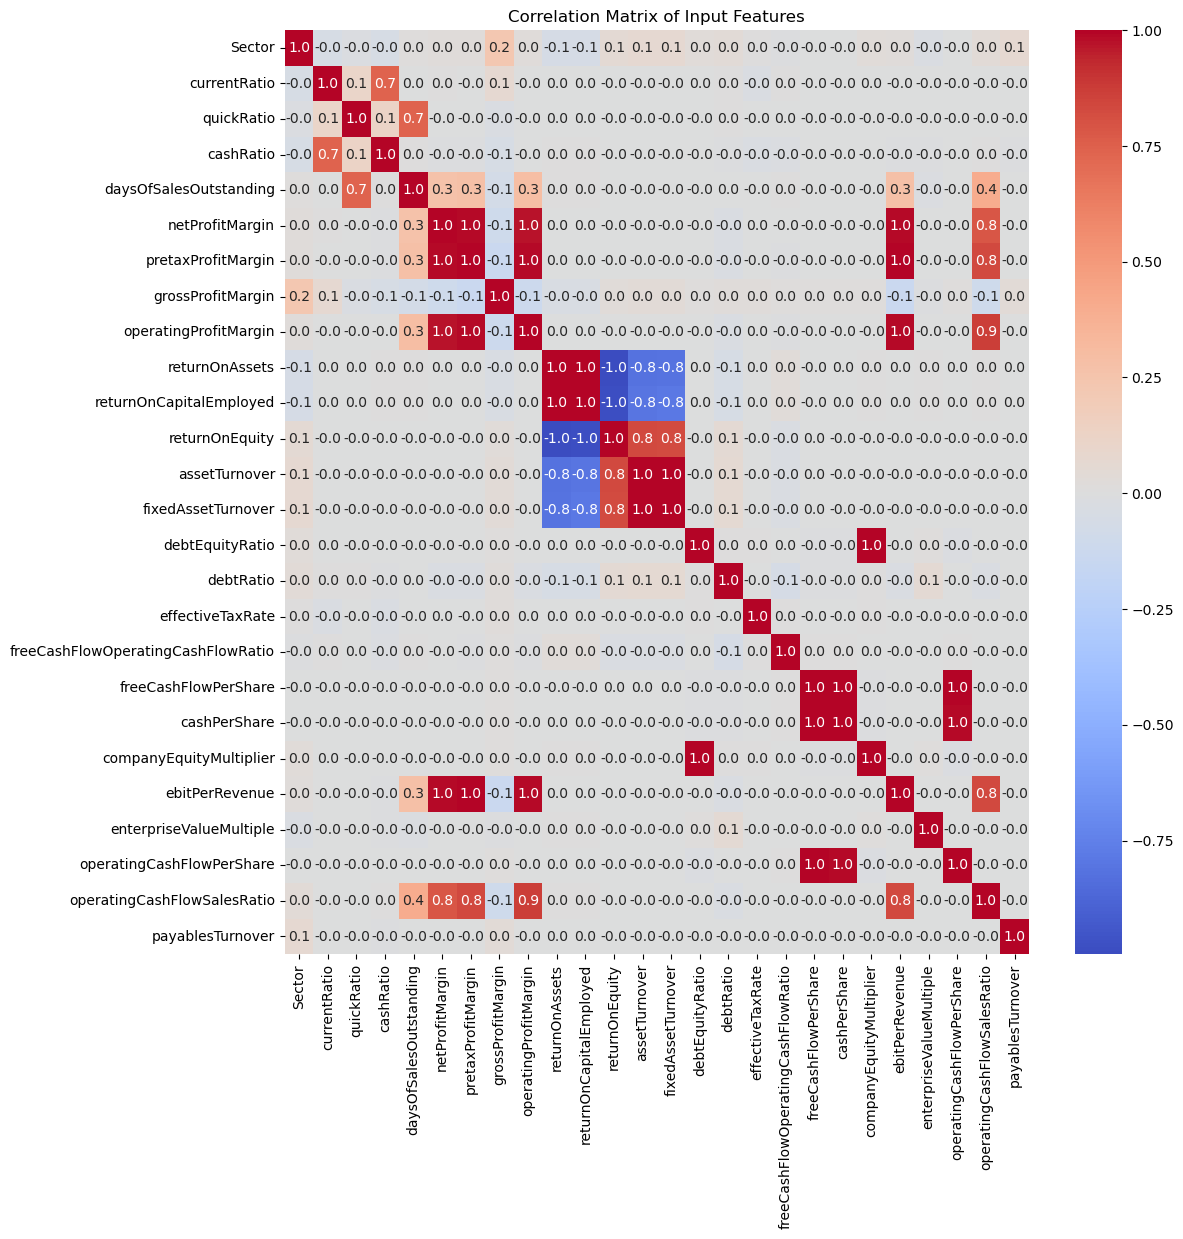

In [15]:
# Compute the correlation matrix
correlation_matrix = ratings_df.iloc[:,1:].corr()

# Plot the correlation matrix as a heatmap
plt.figure(figsize=(12, 12))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".1f")
plt.title("Correlation Matrix of Input Features")
plt.show()

Few points can be understood from the correlation matrix:

- Companies with higher Return on Equity tend to also have higher Asset Turnover and Fixed Asset Turnover, indicating that they efficiently use their assets, both overall and fixed assets, to generate profits.

- A negative correlation between Return on Equity, Asset Turnover, and Fixed Asset Turnover with Return on Assets suggests a trade-off or inverse relationship. It may indicate that companies with high Return on Equity, efficient Asset Turnover, and effective use of Fixed Assets might not be as focused on maximizing profits from their total assets. Companies might be prioritizing shareholder returns (ROE) and operational efficiency (Asset Turnover, Fixed Asset Turnover) over maximizing profits from the entire asset base.

# Normalize the data

Features exhibit different scales, as evident from the magnitude of mean and standard deviation values. To ensure equal contribution from all features for machine learning algorithms, feature scaling is performed. The Min-Max scaling technique is applied to normalize the numerical values representing financial indicators. 

> $x_{scaled} = \frac{x - x_{min}}{x_{max} - x_{min}}$

For each column, the `MinMaxScaler` function from `sklearn.preprocessing` is used to transform the values into a standardized range between 0 and 1. The values are then multiplied by 1000, to amplify the scaled values. 

Additionally, a logarithmic transformation is applied to each value using the `np.log10` function, with a small constant (0.01) added to avoid issues with zero values. This dual transformation approach aims to normalize and potentially enhance the interpretability of the financial indicators in the dataset.

In [16]:
from sklearn import preprocessing
min_max_scaler = preprocessing.MinMaxScaler()

for c in ratings_df.columns[2:27]:

    ratings_df[[c]] = min_max_scaler.fit_transform(ratings_df[[c]].to_numpy())*1000
    ratings_df[[c]] = ratings_df[[c]].apply(lambda x: np.log10(x+0.01))

ratings_df.describe()

,Rating,Sector,currentRatio,quickRatio,cashRatio,daysOfSalesOutstanding,netProfitMargin,pretaxProfitMargin,grossProfitMargin,operatingProfitMargin,...,effectiveTaxRate,freeCashFlowOperatingCashFlowRatio,freeCashFlowPerShare,cashPerShare,companyEquityMultiplier,ebitPerRevenue,enterpriseValueMultiple,operatingCashFlowPerShare,operatingCashFlowSalesRatio,payablesTurnover
count,2021.000000,2021.000000,2021.000000,2021.000000,2021.000000,2021.000000,2021.000000,2021.000000,2021.000000,2021.000000,...,2021.000000,2021.000000,2021.000000,2021.000000,2021.000000,2021.000000,2021.000000,2021.000000,2021.000000,2021.000000
mean,1.513112,4.977239,0.178812,0.430726,0.631910,0.877731,2.529070,2.456102,2.939111,2.366071,...,2.275842,2.889801,-0.059118,-1.766963,2.696696,2.456123,2.402413,0.275069,0.837216,0.617957
std,1.303252,3.464598,0.225495,0.187378,0.318760,0.151604,0.102201,0.100888,0.110645,0.099296,...,0.115144,0.109876,0.120155,0.304634,0.104911,0.100888,0.103841,0.111685,0.147403,0.129440
min,0.000000,0.000000,-2.000000,-2.000000,-2.000000,-2.000000,-2.000000,-2.000000,-2.000000,-2.000000,...,-2.000000,-2.000000,-2.000000,-2.000000,-2.000000,-2.000000,-2.000000,-2.000000,-2.000000,-2.000000
25%,0.000000,2.000000,0.068458,0.341699,0.411708,0.854768,2.530398,2.457200,2.933941,2.366829,...,2.278590,2.891698,-0.063873,-1.843845,2.698694,2.457208,2.401472,0.270167,0.816562,0.588557
50%,2.000000,5.000000,0.150608,0.402510,0.591088,0.864772,2.530583,2.457407,2.939157,2.367049,...,2.279247,2.893039,-0.063723,-1.830634,2.698797,2.457416,2.401823,0.270240,0.822176,0.607754
75%,3.000000,8.000000,0.255607,0.468259,0.812720,0.873261,2.530794,2.457616,2.951412,2.367285,...,2.279548,2.893726,-0.063539,-1.804719,2.698968,2.457632,2.402242,0.270347,0.832122,0.626899
max,3.000000,11.000000,3.000004,3.000004,3.000004,3.000004,3.000004,3.000004,3.000004,3.000004,...,3.000004,3.000004,3.000004,3.000004,3.000004,3.000004,3.000004,3.000004,3.000004,3.000004


# Save the processed data

In [17]:
ratings_df.to_csv('input_corporate_rating.csv', index=False)

This work in exploring and preparing our dataset, sets the stage for the next phase: deploying different machine learning models to forecast credit ratings.